In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import sys
from iminuit import Minuit
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import os

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.inspection import permutation_importance

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [4]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [5]:
COLOUR = ['#1E90FF', # 0 # Dodgerblue
          '#FFBF00', # 1 # Amber
          '#FF6347', # 2 # Tomato
          '#00A86B', # 3 # Jade
          '#8A2BE2', # 4 # Blueviolet
          '#FF6FFF', # 5 # Ultra Pink
          '#00CCFF', # 6 # Vivid Sky Blue
          '#00ff40', # 7 # Erin
          '#FF004F', # 8 # Folly
          '#0063A6', # 9 # Lapis Lazuli
        ]
def setMplParam(classNum):
    # Define effective colors, line styles, and markers based on the class number
   
    LINE = ['-', '-.', '--', '-.', ':','--','-.','-', ':', '--']
    MARKER = ['.','*', '^', 's', '.', 'p', 'o', 's', '.', 'd']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]

    # Set the color cycle for lines including color, line style, and marker
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                       plt.cycler(linestyle=LINE_EFF)+
                                       plt.cycler(marker=MARKER_EFF))

    # Set default line and marker sizes
    plt.rcParams['lines.markersize'] = 3  # Example size
    plt.rcParams['lines.linewidth'] = 2   # Example width for lines

    # Set label and title sizes
    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    # Set tick properties
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20

    # Set legend font size
    plt.rcParams['legend.fontsize'] = 12

    # Enable and configure grid
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    # Set axes line width
    plt.rcParams['axes.linewidth'] = 2

    # Set tick sizes and widths
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['xtick.major.width'] = 3
    plt.rcParams['xtick.minor.size'] = 2
    plt.rcParams['xtick.minor.width'] = 2

    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['ytick.major.width'] = 3
    plt.rcParams['ytick.minor.size'] = 2
    plt.rcParams['ytick.minor.width'] = 2

setMplParam(10)


In [130]:
def getData(fileName, isBlind = False):
    resource = ''
    data = pd.read_csv(resource + fileName)
    if isBlind:
        data.columns = ['ID','Gender','ScheduledDay','AppointmentDay','TimeDifference','Age','Neighbourhood','R1','Diabetes','Alcoholism','Handcap','SMS_received']
    else:
        data.columns = ['ID','Gender','ScheduledDay','AppointmentDay','TimeDifference','Age','Neighbourhood','R1','Diabetes','Alcoholism','Handcap','SMS_received','No-show']
    return data

In [131]:
test = getData('prob4_TestData.csv')
train = getData('prob4_TrainData.csv')
blind = getData('prob4_BlindData.csv', isBlind = True)

In [170]:
classifiers = [LogisticRegression(max_iter=1000),
                     RandomForestClassifier(),
                     AdaBoostClassifier(),
                     GradientBoostingClassifier(),
                     xgb.XGBClassifier()]
classifierNames = ['Logistic Regression',
                        'Random Forest',
                        'AdaBoost',
                        'Gradient Boosting',
                        'XGBoost']
thresholds = [
                0.52, # Logistic Regression
                0.6, # Random Forest
                0.5, # AdaBoost
                0.5, # Gradient Boosting
                0.6  # XGBoost
                ]


* `classifyCore` is for the prediction

In [157]:
def classifyCore(classifier, train, test, features, target, blind, threshold):
    classifier.fit(train[features], train[target])

    test_probabilities = classifier.predict_proba(test[features])[:,1]
    blind_probabilities = classifier.predict_proba(blind[features])[:,1]
    
    test['prediction'] = (test_probabilities >= threshold).astype(int)
    blind['prediction'] = (blind_probabilities >= threshold).astype(int)

    test['probability'] = test_probabilities
    blind['probability'] = blind_probabilities

    cm = confusion_matrix(test[target], test['prediction'])
    precision = precision_score(test[target], test['prediction'])
    testPrediction = test[['ID','prediction','probability']]
    blindPrediction = blind[['ID','prediction','probability']]

    return cm, precision, testPrediction, blindPrediction


In [180]:
def sortByImportance(classifier, X_train, y_train, X_test, y_test):
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
        indices = np.argsort(importances)[::-1]
        rankedFeatures = [(X_train.columns[i], importances[i]) for i in indices]
        
    elif hasattr(classifier, 'coef_'):
        try:
            importances = np.abs(classifier.coef_[0])
            indices = np.argsort(importances)[::-1]
            rankedFeatures = [(X_train.columns[i], importances[i]) for i in indices]
        except TypeError:
            importances = np.abs(classifier.coef_).mean(axis=0)
            indices = np.argsort(importances)[::-1]
            rankedFeatures = [(X_train.columns[i], importances[i]) for i in indices]

    else:
        result = permutation_importance(classifier, X_test, y_test, n_repeats=10, random_state=42)
        indices = result.importances_mean.argsort()[::-1]
        rankedFeatures = [(X_train.columns[i], result.importances_mean[i]) for i in indices]
    
    return rankedFeatures


In [185]:
def saveNoShowID(prediction):
    nsFalseFileName = 'jo.AMAS_Exam.Problem4.NoShowFalse.txt'
    nsTrueFileName = 'jo.AMAS_Exam.Problem4.NoShowTrue.txt'
    ID_ns_0 = prediction[prediction['prediction'] == 0]['ID']
    ID_ns_1 = prediction[prediction['prediction'] == 1]['ID']
    ID_ns_0.to_csv(nsFalseFileName, index = False, header = False)
    ID_ns_1.to_csv(nsTrueFileName, index = False, header = False)

In [177]:
def classify():
    features = ['Gender','ScheduledDay','AppointmentDay','TimeDifference','Age','Neighbourhood','R1','Diabetes','Alcoholism','Handcap','SMS_received']
    target = 'No-show'
    selectedName = 'Gradient Boosting'
    results = {}
    for classifier, name, threshold in zip(classifiers, classifierNames, thresholds):
        cm, precision, testPrediction, blindPrediction = classifyCore(classifier, train, test, features, target, blind, threshold)
        rankedFeatures = sortByImportance(classifier, train[features], train[target], test[features], test[target])
        
        results[name] = {
            'Confusion Matrix': cm, 
            'Precision': precision, 
            'Test Prediction': testPrediction,
            'Blind Prediction': blindPrediction,
            'Ranked Features': rankedFeatures
        }
        if name == selectedName:
            saveNoShowID(blindPrediction)
    return results


In [161]:
def plotHistoCore(result, name, threshold, isBlind = False):
    fig, ax = plt.subplots(figsize=(14, 10))
    if isBlind:
        ns_0 = result['Blind Prediction'][result['Blind Prediction']['prediction'] == 0]['probability']
        ns_1 = result['Blind Prediction'][result['Blind Prediction']['prediction'] == 1]['probability']
    else:
        ns_0 = result['Test Prediction'][result['Test Prediction']['prediction'] == 0]['probability']
        ns_1 = result['Test Prediction'][result['Test Prediction']['prediction'] == 1]['probability']

    N = len(ns_0) + len(ns_1)
    Nbins = int(np.sqrt(N)/3)
    combined = np.concatenate([ns_0, ns_1])
    bins = np.linspace(combined.min(), combined.max(), Nbins)
    
    ax.hist(ns_0, bins=bins, color='red', alpha=0.6, label='No-show==0', histtype='step', hatch='\\\\//', linestyle='-')
    ax.hist(ns_1, bins=bins, color='black', alpha=0.6, label='No-show==1', histtype='step', hatch='//', linestyle='-')
    ax.axvline(x=threshold, linestyle='--', label=f'Threshold: {threshold}')
    
    ax.set_xlabel('Decision Score (Probability)')
    ax.set_ylabel('Frequency')
    if isBlind:
        title_text = f'Distribution of No-show Predictions on Blind Data by {name}'
    else:
        title_text = f'Distribution of No-show Predictions on Test Data by {name}'
    ax.set_title(title_text)
    ax.legend(loc='upper right')

    d_hist = {
        'Histo': 'param',
        'N bins': len(bins),
        'bin width': bins[1] - bins[0],
    }
    
    accuracy = (len(ns_0) + len(ns_1) - len(ns_1[ns_1 > threshold])) / N
    precision = result['Precision']
    error = np.sqrt(precision*(1-precision)/N)

    if isBlind:
        d_data = {
            'Data': '(blind)',
            'N test': N,
            'N blind': len(result['Blind Prediction']),
            'N show': len(ns_0),
            'N no_show': len(ns_1),
            'Accuracy': accuracy,
            'Precision': precision,
            'Threshold': threshold,
            'Error': error
        }
    else: 
        d_data = {
            'Data': '(test)',
            'N test': N,
            'N show': len(ns_0),
            'N no_show': len(ns_1),
            'Accuracy': accuracy,
            'Precision': precision,
            'Threshold': threshold,
            'Error': error
        }
    
    d_cm = {
        'Confusion': 'Matrix',
        'TP': result['Confusion Matrix'][1][1],
        'FP': result['Confusion Matrix'][0][1],
        'TN': result['Confusion Matrix'][0][0],
        'FN': result['Confusion Matrix'][1][0],
        }
    ranked = result['Ranked Features']

    d_rank = {'Ranking':  'Importance'}
    for i, (feature, importance) in enumerate(ranked):
        d_rank[f'{i+1:2d}. {feature}'] = f'{importance:.3f}'
    
    text_histo = nice_string_output(d_hist, extra_spacing=2, decimals=3)
    text_data = nice_string_output(d_data, extra_spacing=2, decimals=3)
    text_cm = nice_string_output(d_cm, extra_spacing=2, decimals=3)
    text_rank = nice_string_output(d_rank, extra_spacing=2, decimals=3)
    x0 = 0.65
    y0 = 0.93
    if name == 'AdaBoost':
        x0 = 0.05
    add_text_to_ax(x0, y0, text_histo, ax, fontsize=12)
    add_text_to_ax(x0, y0 - 0.13, text_data, ax, fontsize=12)
    add_text_to_ax(x0 + 0.2, y0 - 0.13, text_cm, ax, fontsize=12)
    add_text_to_ax(x0, y0 - 0.40, text_rank, ax, fontsize=12)

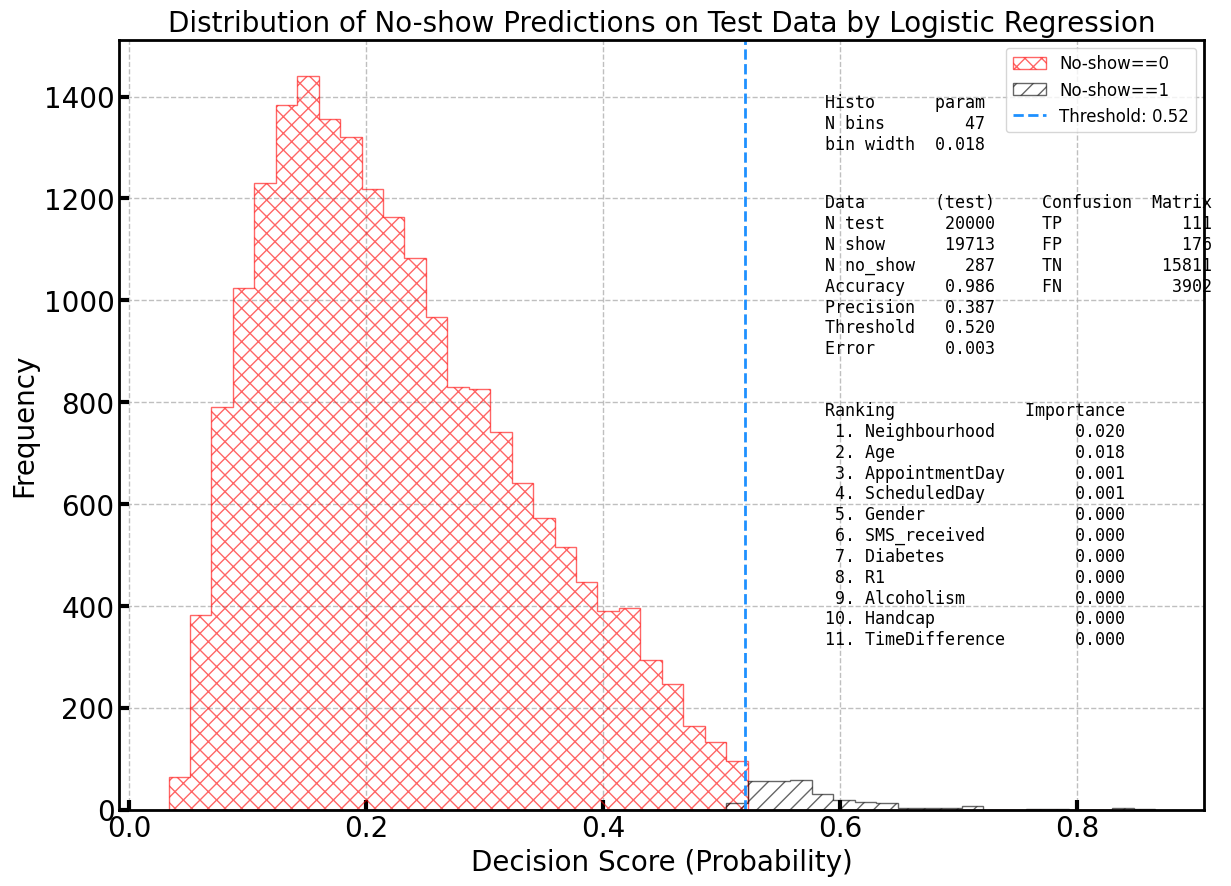

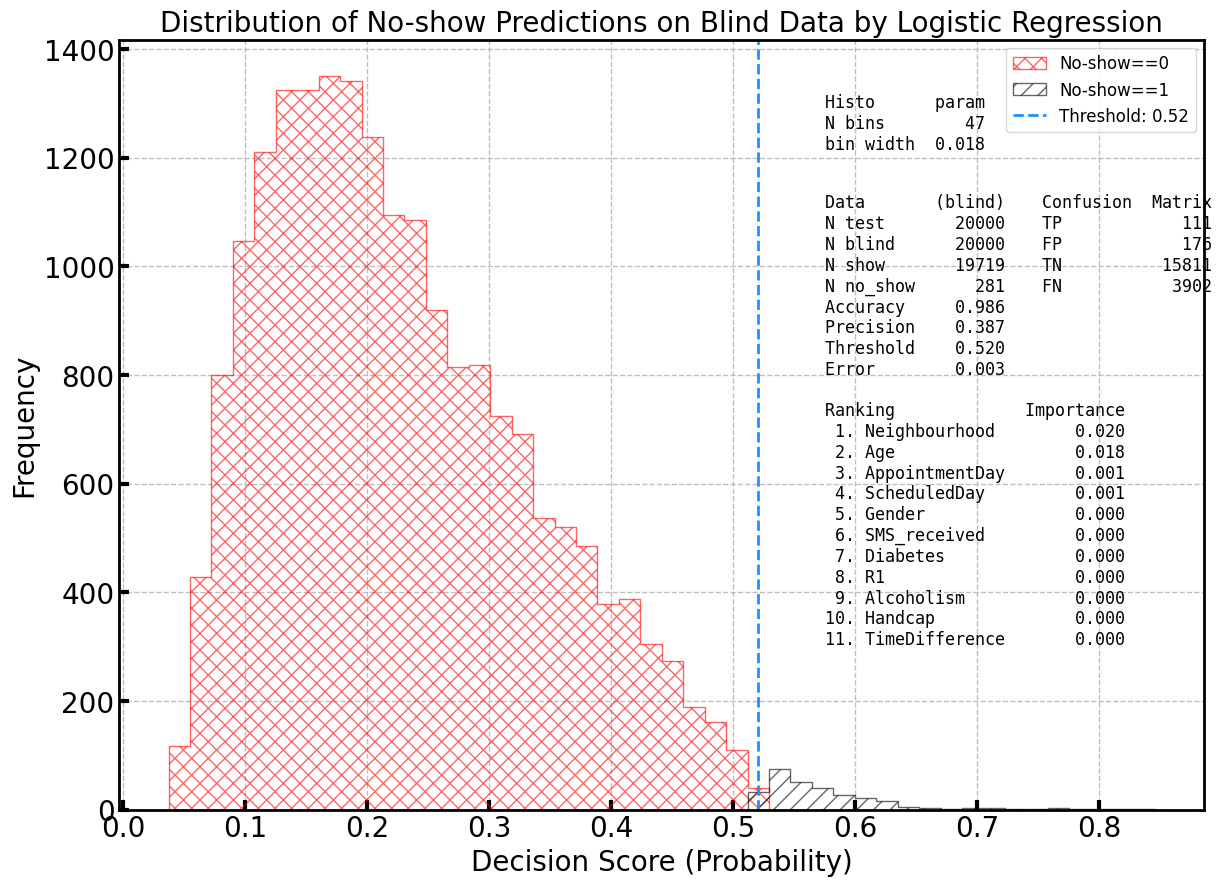

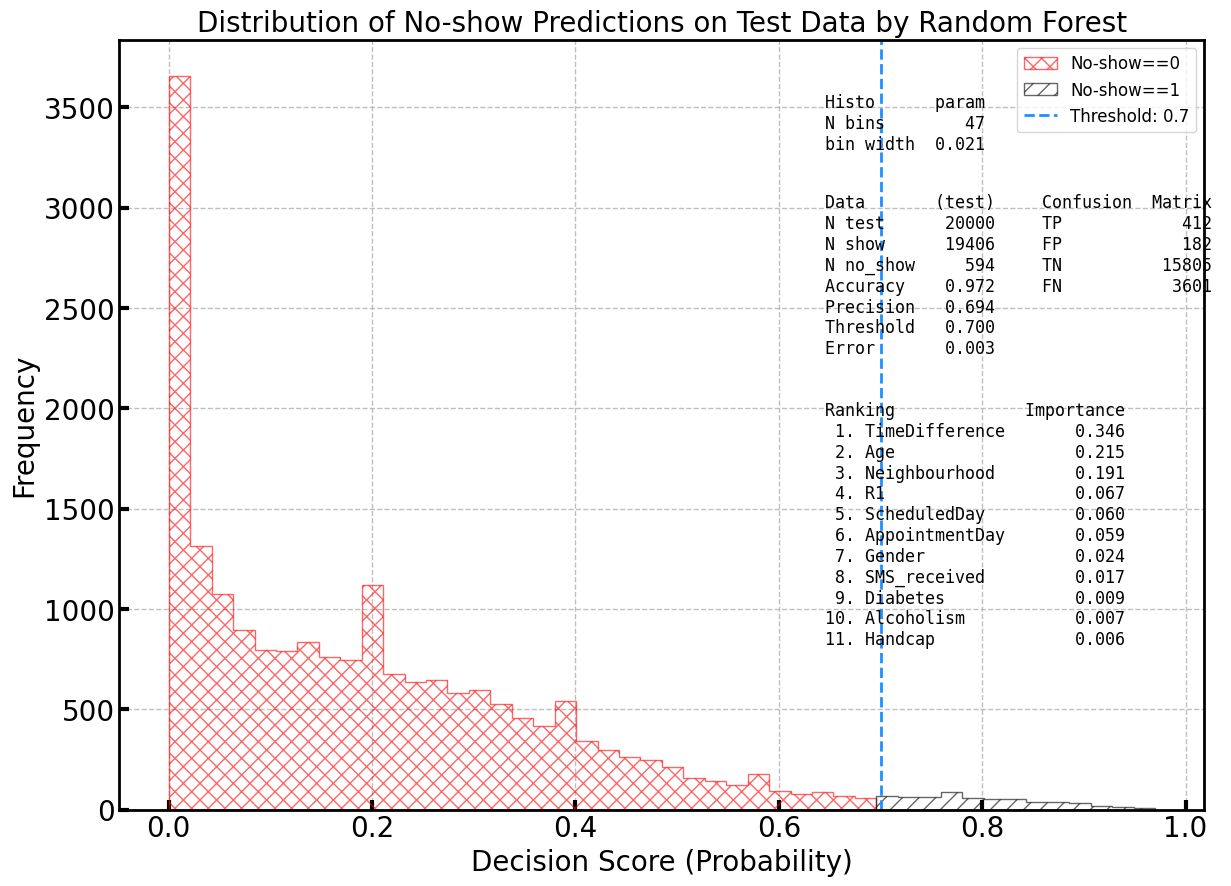

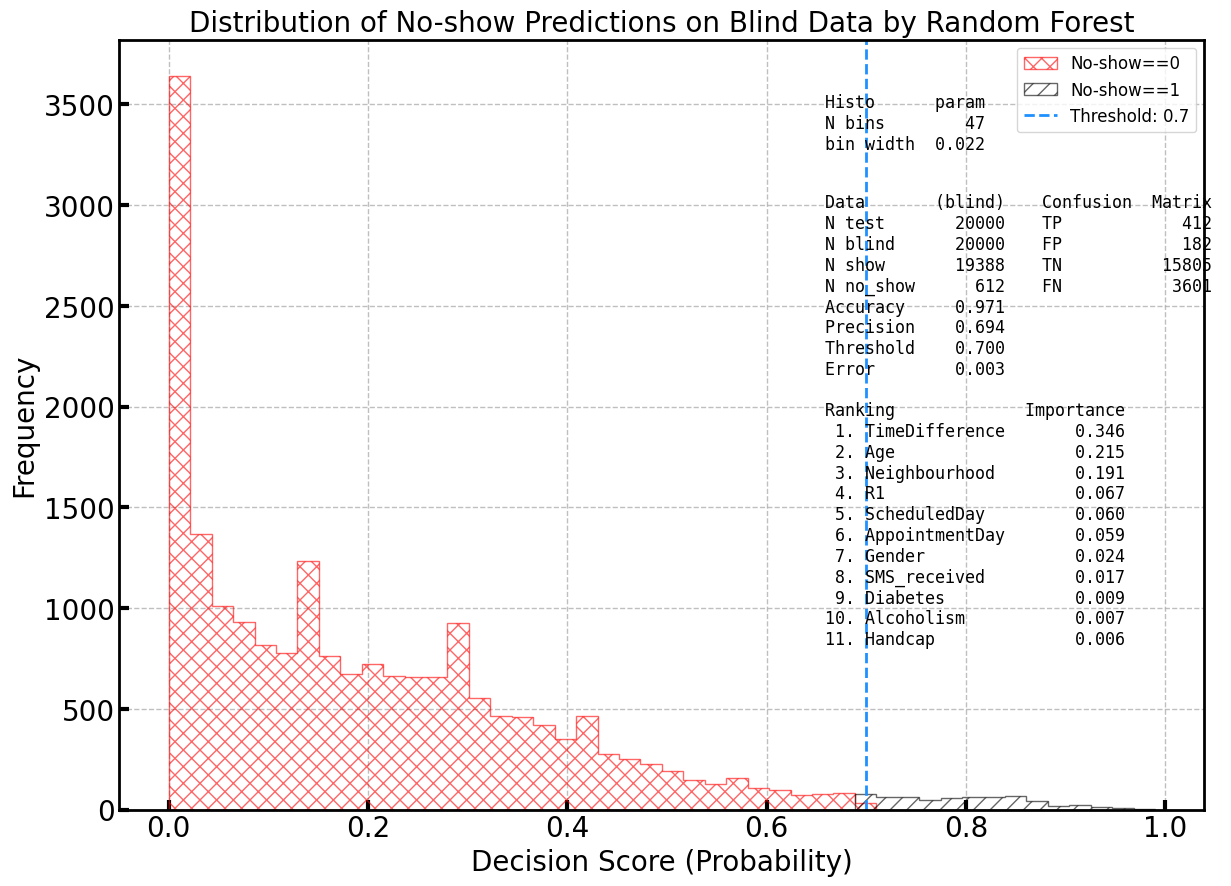

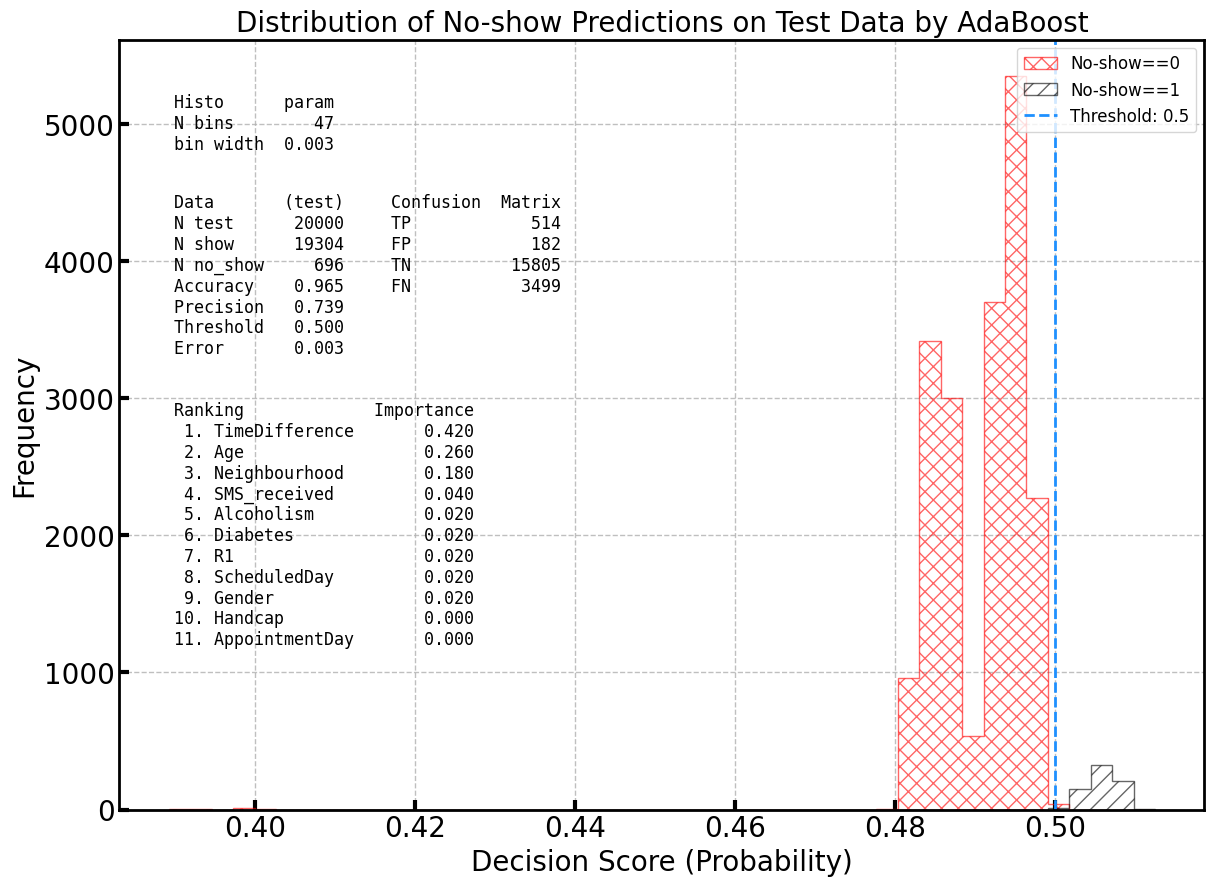

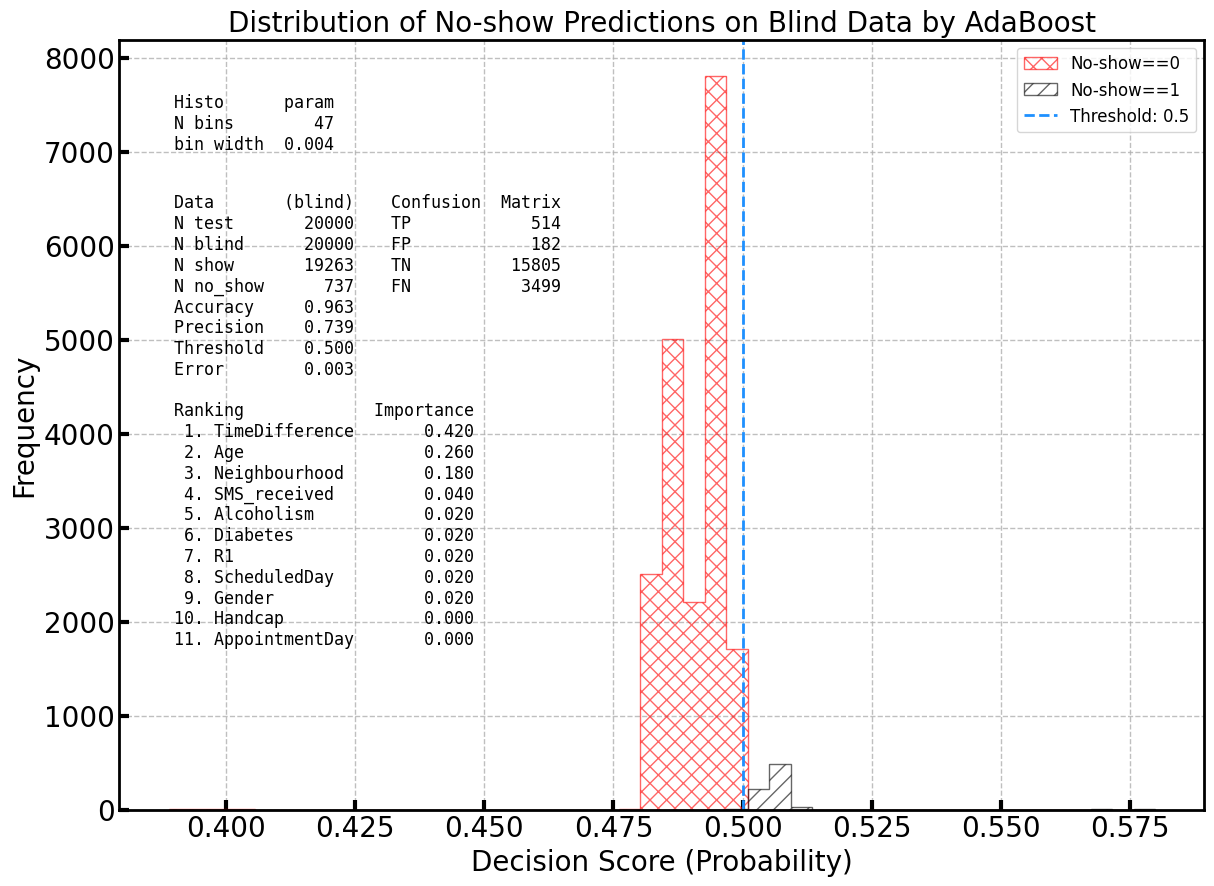

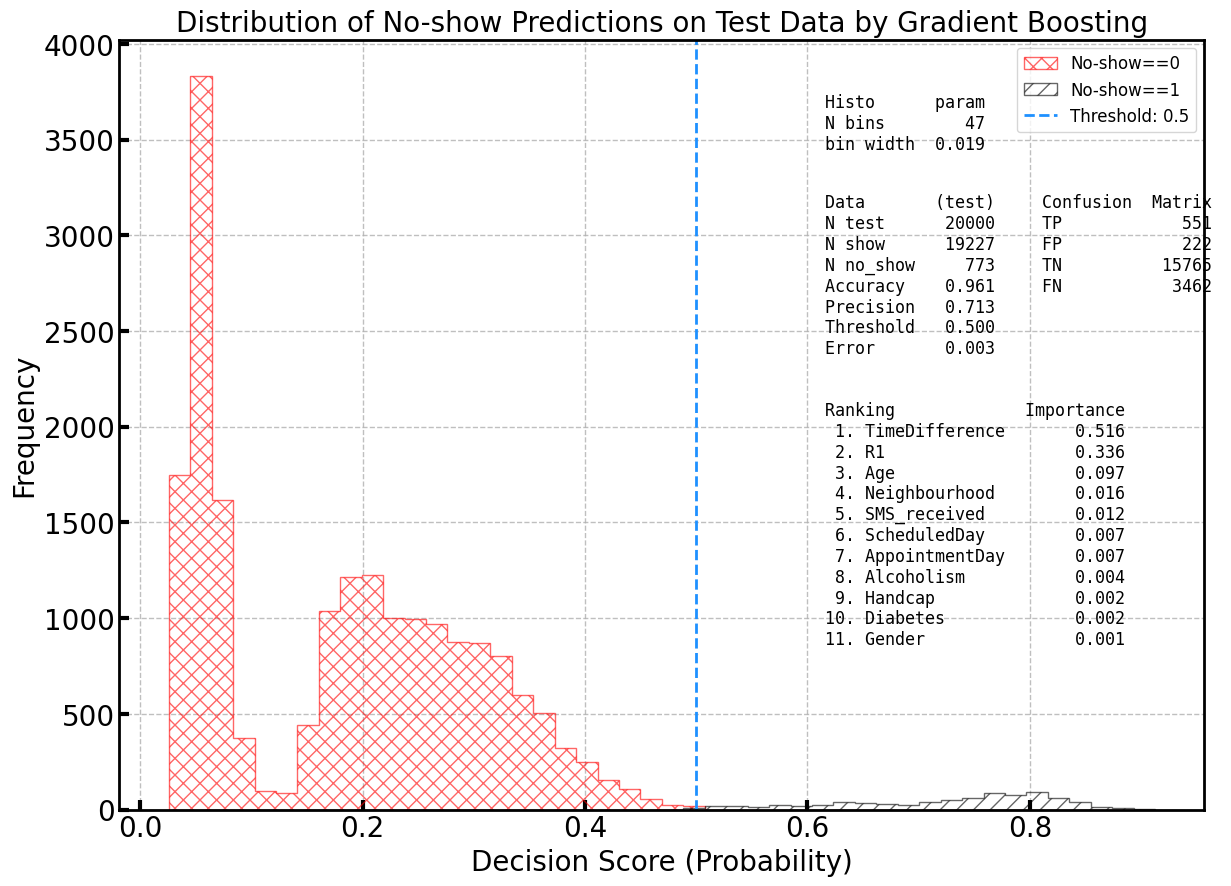

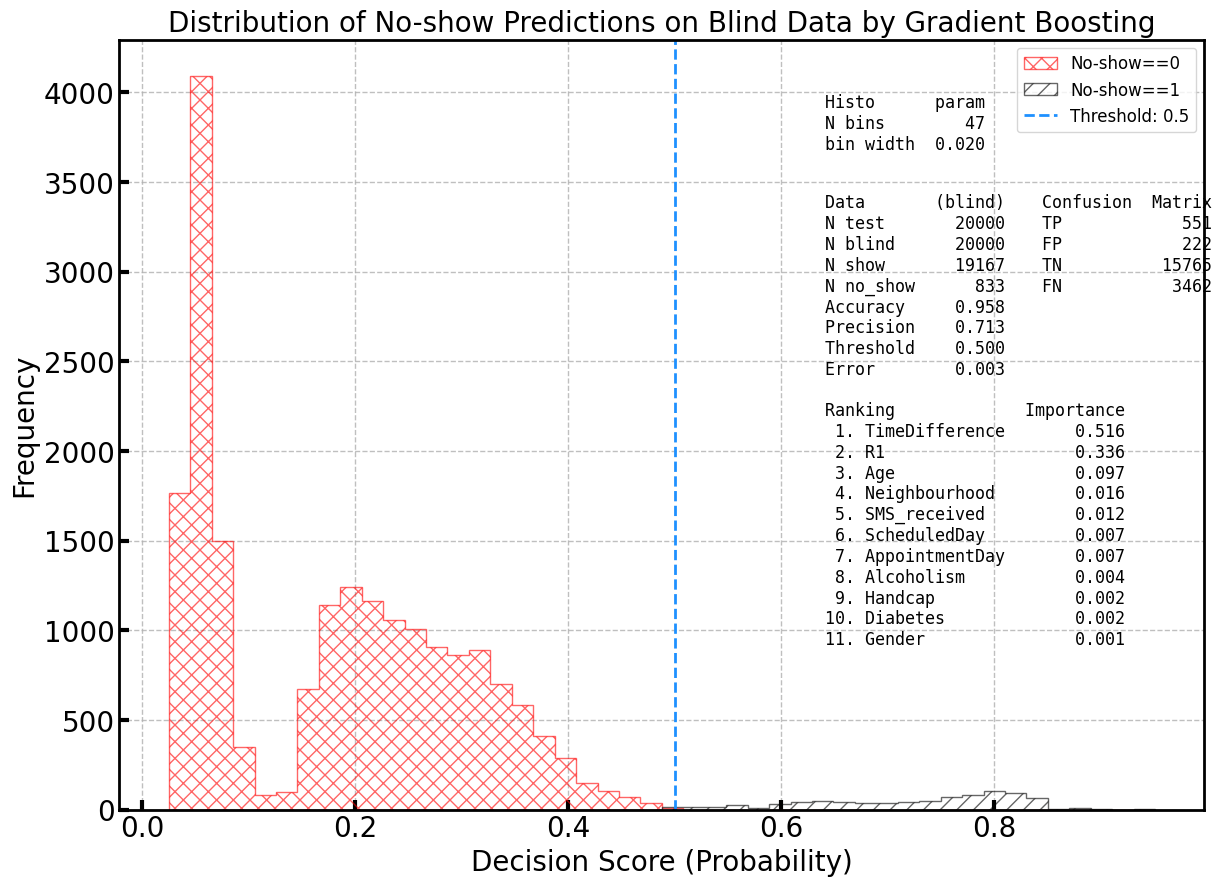

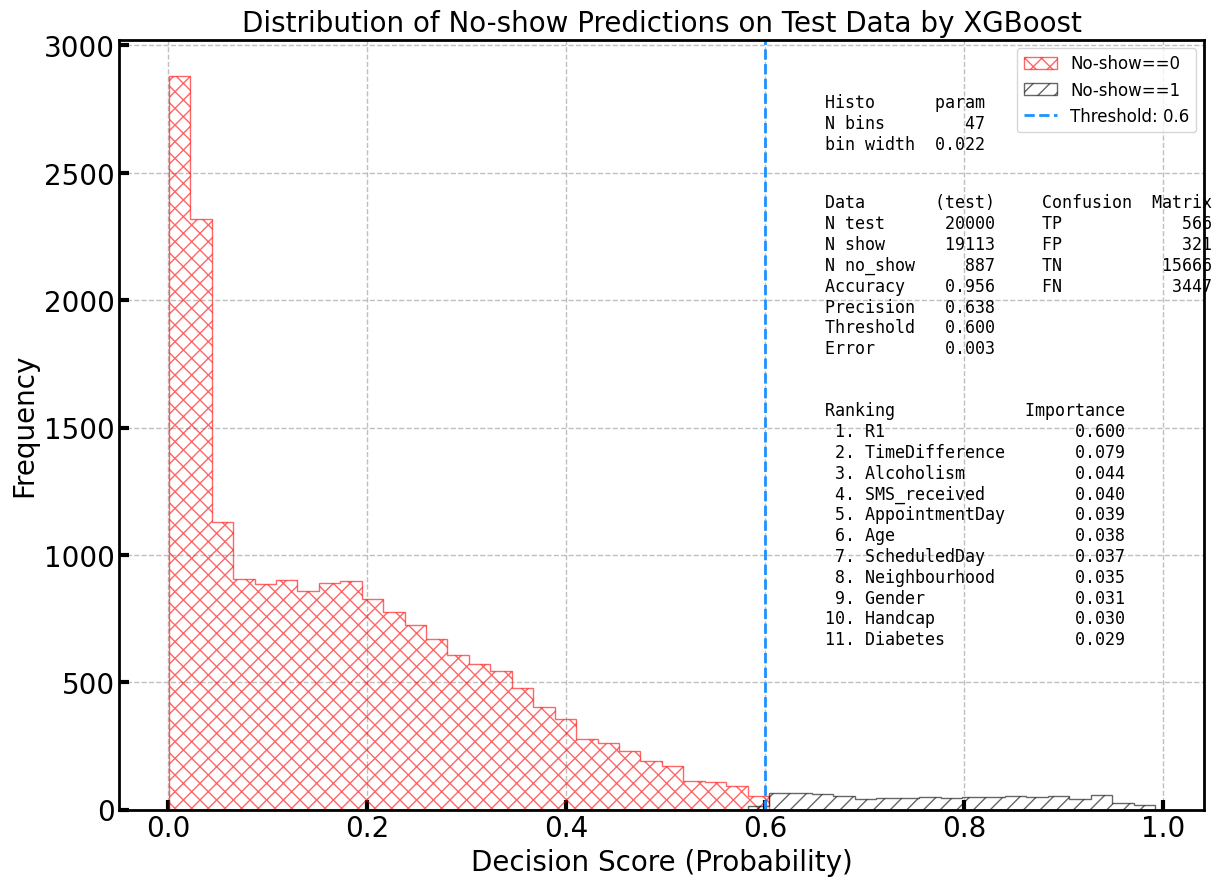

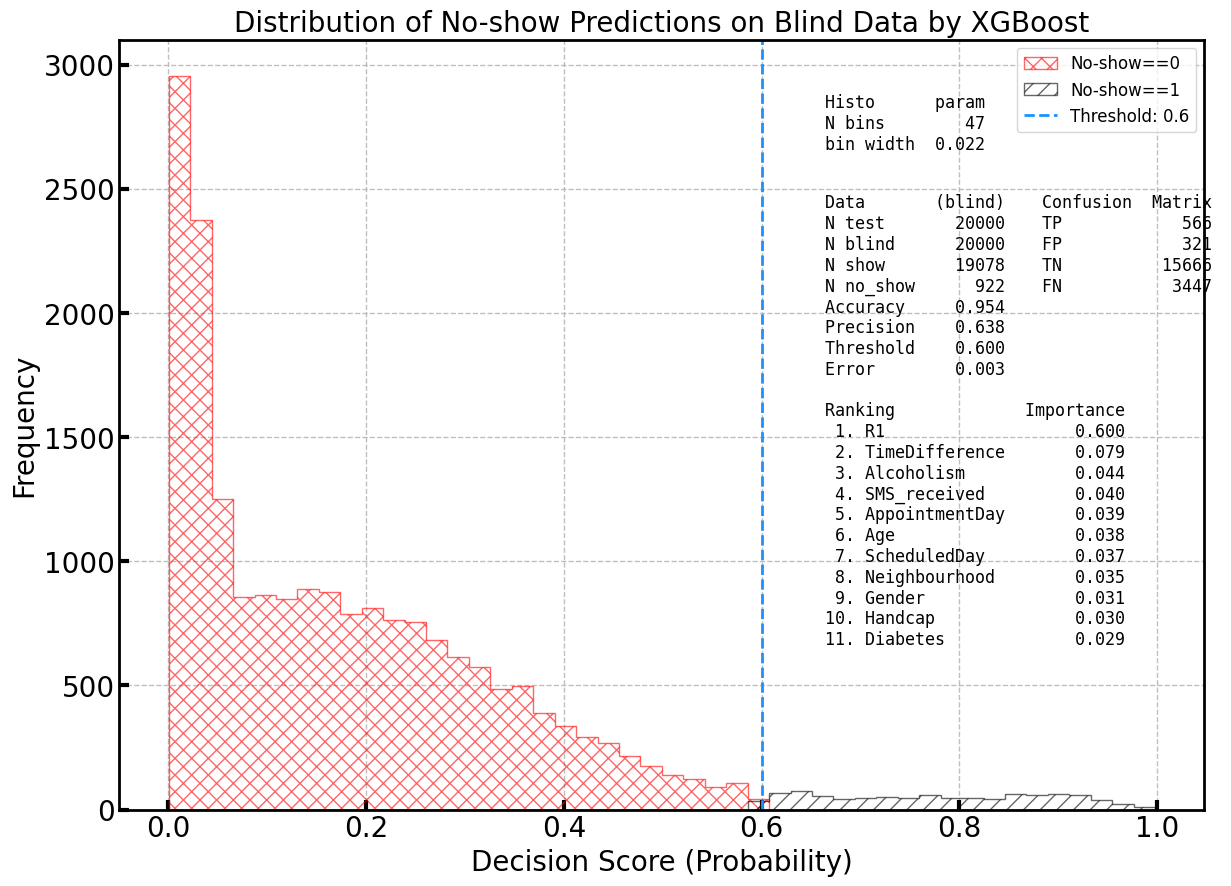

In [184]:
def plotHisto():
    for name, threshold in zip(classifierNames, thresholds):
        result = results[name]
        plotHistoCore(result, name, threshold)
        plotHistoCore(result, name, threshold, isBlind = True)
results = classify()
plotHisto()

In [128]:
def displayStats(test_show, test_no_show, blind_show, blind_no_show):
    def format_row(label, test_data_show, test_data_no_show, blind_data_show, blind_data_no_show):
        return (f"{label} & "
                f"{test_data_show.mean():.2f} & {test_data_show.median():.0f} & {test_data_show.std():.2f} & "
                f"{test_data_no_show.mean():.2f} & {test_data_no_show.median():.0f} & {test_data_no_show.std():.2f} & "
                f"{blind_data_show.mean():.2f} & {blind_data_show.median():.0f} & {blind_data_show.std():.2f} & "
                f"{blind_data_no_show.mean():.2f} & {blind_data_no_show.median():.0f} & {blind_data_no_show.std():.2f} \\\\")

    print("\\textbf{Feature} & "
          "\\multicolumn{3}{c|}{\\textbf{Test Show}} & "
          "\\multicolumn{3}{c|}{\\textbf{Test No Show}} & "
          "\\multicolumn{3}{c|}{\\textbf{Blind Show}} & "
          "\\multicolumn{3}{c}{\\textbf{Blind No Show}} \\\\ \\hline")
    print("\\textbf{} & \\textbf{Mean} & \\textbf{Median} & \\textbf{Std Dev} & "
          "\\textbf{Mean} & \\textbf{Median} & \\textbf{Std Dev} & "
          "\\textbf{Mean} & \\textbf{Median} & \\textbf{Std Dev} & "
          "\\textbf{Mean} & \\textbf{Median} & \\textbf{Std Dev} \\\\ \\hline")
    
    for feature in test_show.columns:
        if test_show[feature].dtype in ['int64', 'float64']:
            print(format_row(feature, test_show[feature], test_no_show[feature], blind_show[feature], blind_no_show[feature]))
            print("\\hline")

    


In [105]:
def displayConfusionMatrix(TN, FP, FN, TP):
    print(f'Confusion matrix:')
    print('& Negative & Positive \\\\ \hline')
    print('False &', FN, '&', FP, '\\\\')
    print('True &', TN, '&', TP, '\\\\')
    print()

In [118]:
def showCM(name):
    result = results[name]
    displayConfusionMatrix(*result['Confusion Matrix'].ravel())
    print()

In [119]:
showCM('Logistic Regression')

Classifier: Logistic Regression
Confusion matrix:
& Negative & Positive \\ \hline
False & 3861 & 253 \\
True & 15734 & 152 \\


